In [ ]:
import numpy as np
import pandas as pd
import os
import sys
import csv
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.image as mpimg
import optuna
import random
import joblib
import math
import logging
from msig import Motif, NullModel
from config import RESULTS_MOTIF_DIR, RESULTS_DIR, IMAGES_DIR, DATA_DIR, DATASET_PATH, TOWNSHIP_NAME, VARIABLES, STUMPY_EXCL_ZONE_DENOM, TOP_K_MP, INCLUDE, NORMALIZE, SUBSQUENCES_LENGTHS

print(f"Results will be saved in: {RESULTS_DIR}")
print(f"Images will be saved in: {IMAGES_DIR}")
print(f"Data will be accessed from: {DATA_DIR}")


if '__file__' in globals():
    # For standalone scripts
    base_dir = os.path.dirname(__file__)
else:
    # For Jupyter or interactive environments
    base_dir = os.getcwd()

# Add the parent directory of `utils` to the Python path
sys.path.append(os.path.abspath(os.path.join(base_dir, "../")))

2025-01-10 12:30:33,768 - INFO - Results will be saved in: /home/mgsilva/motifpred/results/populationdensity
2025-01-10 12:30:33,769 - INFO - Images will be saved in: /home/mgsilva/motifpred/images/populationdensity
2025-01-10 12:30:33,769 - INFO - Data will be accessed from: /home/mgsilva/motifpred/data/populationdensity


Results will be saved in: /home/mgsilva/motifpred/results/populationdensity
Images will be saved in: /home/mgsilva/motifpred/images/populationdensity
Data will be accessed from: /home/mgsilva/motifpred/data/populationdensity


In [ ]:
# read csv
data_df = pd.read_csv(
    DATASET_PATH,
    parse_dates=["one_time"],
    date_format="%Y-%m-%d %H:%M:%S",
    index_col=0,
)

data_df = data_df[data_df["township_name"] == TOWNSHIP_NAME]
#set index to one_time and township_name
data_df = data_df.set_index(["one_time", "township_name"]).sort_index()[VARIABLES]
data = data_df.to_numpy().T
data_df

,,sum_terminals,sum_roaming_terminals,sum_phonecalls
one_time,township_name,,,
2021-09-15 00:00:00,Avenidas Novas,260700.0,17678.0,2262.0
2021-09-15 01:00:00,Avenidas Novas,276675.0,17533.0,994.0
2021-09-15 02:00:00,Avenidas Novas,284563.0,15280.0,725.0
2021-09-15 03:00:00,Avenidas Novas,279563.0,12424.0,393.0
2021-09-15 04:00:00,Avenidas Novas,281460.0,10789.0,290.0
...,...,...,...,...
2021-11-30 19:00:00,Avenidas Novas,391367.0,12886.0,17569.0
2021-11-30 20:00:00,Avenidas Novas,352361.0,11026.0,13738.0
2021-11-30 21:00:00,Avenidas Novas,388246.0,13957.0,16368.0


In [3]:
# motif discovery
import stumpy
from stumpy import config

config.STUMPY_EXCL_ZONE_DENOM = STUMPY_EXCL_ZONE_DENOM  

for m in SUBSQUENCES_LENGTHS:
    mp, mp_indices = stumpy.mstump(data, m, normalize=NORMALIZE)
    np.save(
        RESULTS_MOTIF_DIR / f"normalized_{NORMALIZE}_top_{TOP_K_MP}_m_{m}_mp.npy",
        mp,
        allow_pickle=True,
    )
    np.save(
        RESULTS_MOTIF_DIR / f"normalized_{NORMALIZE}_top_{TOP_K_MP}_m_{m}_mp_indices.npy",
        mp_indices,
        allow_pickle=True,
    )

2025-01-10 12:30:35,255 - INFO - init


In [4]:
def multivar_subsequence_complexity(x):
    # complexity for multivariate time series can be calculated as the sum of the complexity of each dimension
    return np.sum(np.sqrt(np.sum(np.square(np.diff(x)), axis=1)))


def table_summary_motifs(
    motif_indices,
    motif_distances,
    motif_subspaces,
    data,
    k_distances,
    m,
    normalize,
    max_allowed_dist,
):
    mp_stats_table = pd.DataFrame(
        columns=[
            "ID",
            "k_distances",
            "Features",
            "m",
            "#Matches",
            "Indices",
            "max(dists)",
            "min(dists)",
            "med(dists)",
        ]
    )

    motif_index = 0

    n_vars, n_time = data.shape

    if normalize:
        data = (data - np.mean(data, axis=1)[:, np.newaxis]) / np.std(data, axis=1)[
            :, np.newaxis
        ]

    dtypes = [float] * len(data)
    model_empirical = NullModel(data, dtypes, model="empirical")

    for motif_indice, match_indices in enumerate(motif_indices):
        dimensions = motif_subspaces[motif_indice]

        # remove filling values of -1 and Nans from motif_indices and match_distances
        match_indices = match_indices[match_indices != -1]
        match_distances = motif_distances[motif_indice]
        match_distances = match_distances[~np.isnan(match_distances)]

        # if is empty, skip
        if len(match_indices) == 0:
            continue

        excl_zone = np.ceil(m / config.STUMPY_EXCL_ZONE_DENOM)

        # remove trivial matches
        non_trivial_matches = []
        for indice in match_indices:
            trivial = False
            for indice_new in non_trivial_matches:
                if abs(indice - indice_new) <= excl_zone:
                    trivial = True
                    break
            if not trivial:
                non_trivial_matches.append(indice)
        match_indices = non_trivial_matches

        max_possible_matches = int(np.floor((n_time - m) / excl_zone + 1))

        # get the multidim time serie motif in the dimensions
        multivar_subsequence = data[dimensions][
            :, match_indices[0] : match_indices[0] + m
        ]

        # minmax normalize subsequence
        epsilon = 1e-10  # to avoid division by zero
        min_values = multivar_subsequence.min(axis=1, keepdims=True)
        max_values = multivar_subsequence.max(axis=1, keepdims=True)
        normalized_multivar_subsequence = (multivar_subsequence - min_values) / (
            max_values - min_values + epsilon
        )
        ce_norm_subsequence = multivar_subsequence_complexity(
            normalized_multivar_subsequence
        )
        norm_ce_norm_subsequence = ce_norm_subsequence / (
            np.sqrt(len(multivar_subsequence[0]) - 1) * len(dimensions)
        )

        max_dist = np.max(match_distances)
        min_dist = np.min(match_distances[1:])

        if k_distances is None:  # consider all matches
            med_dist = np.median(match_distances[1:])
        else:  # consider only the k closest matches
            med_dist = np.median(match_distances[1 : k_distances + 1])

        # np.nanmax([np.nanmean(D) - 2.0 * np.nanstd(D), np.nanmin(D)])
        if max_allowed_dist is None:
            current_data = data[dimensions]
            n_vars, n_time = current_data.shape

            # D The distance profile of `Q` with `T`. It is a 1D numpy array of size
            # `len(T)-len(Q)+1`, where `D[i]` is the distance between query `Q` and
            # `T[i : i + len(Q)]`
            D = np.empty((n_vars, n_time - m + 1))
            for i in range(n_vars):
                D[i, :] = stumpy.mass(
                    multivar_subsequence[i], current_data[i], normalize=normalize
                )
            D = np.mean(D, axis=0)
            D_copy = D.copy().astype(np.float64)
            D_copy[np.isinf(D_copy)] = np.nan
            motif_max_allowed_dist = np.nanmax(
                [np.nanmean(D_copy) - 2.0 * np.nanstd(D_copy), np.nanmin(D_copy)]
            )
        else:
            motif_max_allowed_dist = max_allowed_dist

        unified_weights = "0.33,0.33,0.33"
        w1, w2, w3 = map(float, unified_weights.split(","))
        unified = (
            w1 * (1 - (med_dist / motif_max_allowed_dist))
            + w2 * (len(match_indices) / max_possible_matches)
            + w3 * norm_ce_norm_subsequence
        )

        # remove timepoints from time series in match all indices + m
        time_series_nomatches = data.copy()
        # list of indexes to remove
        indexes_to_remove = [
            i for index in match_indices for i in range(index, index + m)
        ]
        # put zero in the indexes to remove
        time_series_nomatches[:, indexes_to_remove] = 0

        # calculate variance explained by the motif
        vars_explained = []
        for i in range(len(dimensions)):
            vars_explained.append(
                100
                * (
                    1
                    - (
                        np.mean(np.abs(time_series_nomatches[i]))
                        / np.mean(np.abs(data[i]))
                    )
                )
            )

        variance_explained = np.mean(vars_explained)

        # data features are now the ones in the dimensions
        used_features = [f"{dimension}" for dimension in dimensions]

        # max_delta = motif_max_allowed_dist # (worst case) max_dist = sqrt(max_delta^2) <=> max_delta = max_dist
        max_delta = math.sqrt(motif_max_allowed_dist**2 / m)
        delta_thresholds = [max_delta] * len(data)

        #########SIG#########
        motif = Motif(
            multivar_subsequence, dimensions, delta_thresholds, len(match_indices)
        )
        p = motif.set_pattern_probability(model_empirical, vars_indep=True)
        pvalue = motif.set_significance(
            max_possible_matches, n_vars, idd_correction=False
        )

        stats_df = {
            "ID": str(motif_index),
            "k": len(dimensions),
            "Features": ",".join(used_features),
            "m": m,
            "#Matches": len(match_indices) - 1,
            "Indices": match_indices,
            "max(dists)": np.around(max_dist, 3),
            "min(dists)": np.around(min_dist, 3),
            "med(dists)": np.around(med_dist, 3),
            "CE": np.around(norm_ce_norm_subsequence, 3),
            "Score Unified": np.around(unified, 3),
            "Explained Var(%)": np.around(variance_explained, 2),
            "P": p,
            "p-value": pvalue,
        }

        mp_stats_table = (
            pd.DataFrame.from_records([stats_df])
            if mp_stats_table.empty
            else pd.concat(
                [mp_stats_table, pd.DataFrame.from_records([stats_df])],
                ignore_index=True,
            )
        )

        motif_index += 1
    return mp_stats_table

In [5]:
k_distances = None
min_neighbors = 2
cutoff = np.inf
max_matches = 99999
max_distance = None
max_motifs = 99999
k = 1

# Initialize mp_stats_table outside the loop to accumulate results
mp_stats_table = pd.DataFrame()

for m in SUBSQUENCES_LENGTHS:
    mp = np.load(
        RESULTS_MOTIF_DIR / f"normalized_{NORMALIZE}_top_{TOP_K_MP}_m_{m}_mp.npy",
        allow_pickle=True,
    )
    indices = np.load(
        RESULTS_MOTIF_DIR / f"normalized_{NORMALIZE}_top_{TOP_K_MP}_m_{m}_mp_indices.npy",
        allow_pickle=True,
    )

    motif_distances, motif_indices, motif_subspaces, motif_mdls = stumpy.mmotifs(
        data,
        mp,
        indices,
        min_neighbors=min_neighbors,
        max_distance=max_distance,
        cutoffs=cutoff,
        max_matches=max_matches,
        max_motifs=max_motifs,
        k=k,
        include=INCLUDE,
        normalize=NORMALIZE,
    )
    if len(motif_indices[0]) == 0:
        continue

    # Create the table for the current iteration
    table = table_summary_motifs(
        motif_indices,
        motif_distances,
        motif_subspaces,
        data,
        k_distances,
        m,
        NORMALIZE,
        max_distance,
    )
    logging.info(
        "m:{}, #Motifs:{}, Sig:{}".format(
            m, len(motif_indices), np.sum(table["p-value"] < 0.001)
        )
    )

    # Apply Hochberg procedure
    p_values = table["p-value"].to_numpy()
    critical_value = NullModel.hochberg_critical_value(p_values, 0.05)
    sig = (
        table["p-value"] < critical_value
        if critical_value != 0
        else table["p-value"] <= critical_value
    )
    table["Sig_Hochber"] = sig

    print(
        "Sig after Hochberg: {}, critical value: {}".format(np.sum(sig), critical_value)
    )

    # Append the current table to mp_stats_table
    mp_stats_table = pd.concat([mp_stats_table, table], ignore_index=True)

# Save the accumulated mp_stats_table to CSV
mp_stats_table.to_csv(
    RESULTS_DIR / f"mp_stats_table_normalized_{NORMALIZE}_top_{TOP_K_MP}.csv",
    index=False,
)

2025-01-10 12:30:39,902 - INFO - p_value = 4.795E-228 (p_pattern = 3.078E-09)
2025-01-10 12:30:39,927 - INFO - p_value = 1.967E-95 (p_pattern = 1.134E-09)
2025-01-10 12:30:39,951 - INFO - p_value = 6.592E-212 (p_pattern = 2.297E-07)
2025-01-10 12:30:39,976 - INFO - p_value = 1.722E-70 (p_pattern = 1.100E-06)
2025-01-10 12:30:40,001 - INFO - p_value = 1.136E-30 (p_pattern = 7.101E-05)
2025-01-10 12:30:40,025 - INFO - p_value = 6.517E-70 (p_pattern = 9.202E-12)
2025-01-10 12:30:40,050 - INFO - p_value = 6.711E-112 (p_pattern = 8.367E-10)
2025-01-10 12:30:40,074 - INFO - p_value = 2.786E-268 (p_pattern = 3.253E-07)
2025-01-10 12:30:40,099 - INFO - p_value = 3.760E-17 (p_pattern = 1.881E-07)
2025-01-10 12:30:40,131 - INFO - p_value = 1.674E-120 (p_pattern = 2.426E-10)
2025-01-10 12:30:40,156 - INFO - p_value = 1.530E-110 (p_pattern = 4.957E-04)
2025-01-10 12:30:40,182 - INFO - p_value = 1.704E-125 (p_pattern = 3.195E-06)
2025-01-10 12:30:40,209 - INFO - p_value = 1.946E-02 (p_pattern = 1.0

Sig after Hochberg: 48, critical value: 0.019461305390526096


2025-01-10 12:30:41,661 - INFO - p_value = 1.319E-184 (p_pattern = 7.450E-10)
2025-01-10 12:30:41,679 - INFO - p_value = 2.980E-25 (p_pattern = 2.620E-05)
2025-01-10 12:30:41,695 - INFO - p_value = 3.073E-216 (p_pattern = 9.004E-11)
2025-01-10 12:30:41,711 - INFO - p_value = 1.132E-297 (p_pattern = 2.907E-07)
2025-01-10 12:30:41,728 - INFO - p_value = 1.211E-164 (p_pattern = 1.619E-06)
2025-01-10 12:30:41,744 - INFO - p_value = 2.216E-202 (p_pattern = 3.742E-06)
2025-01-10 12:30:41,761 - INFO - p_value = 7.747E-13 (p_pattern = 2.718E-07)
2025-01-10 12:30:41,779 - INFO - p_value = 2.692E-27 (p_pattern = 4.117E-12)
2025-01-10 12:30:41,796 - INFO - p_value = 1.370E-19 (p_pattern = 1.564E-04)
2025-01-10 12:30:41,813 - INFO - p_value = 5.342E-141 (p_pattern = 1.329E-09)
2025-01-10 12:30:41,830 - INFO - p_value = 3.961E-20 (p_pattern = 1.009E-09)
2025-01-10 12:30:41,847 - INFO - p_value = 3.221E-131 (p_pattern = 8.767E-09)
2025-01-10 12:30:41,865 - INFO - p_value = 4.446E-65 (p_pattern = 1.7

Sig after Hochberg: 45, critical value: 0.037292304243912784


2025-01-10 12:30:42,878 - INFO - p_value = 2.334E-70 (p_pattern = 2.440E-14)
2025-01-10 12:30:42,887 - INFO - p_value = 3.423E-179 (p_pattern = 7.627E-13)
2025-01-10 12:30:42,896 - INFO - p_value = 2.740E-317 (p_pattern = 2.613E-12)
2025-01-10 12:30:42,905 - INFO - p_value = 2.567E-217 (p_pattern = 2.056E-05)
2025-01-10 12:30:42,914 - INFO - p_value = 1.510E-57 (p_pattern = 3.330E-12)
2025-01-10 12:30:42,924 - INFO - p_value = 2.941E-154 (p_pattern = 2.173E-13)
2025-01-10 12:30:42,933 - INFO - p_value = 0.000E+00 (p_pattern = 2.752E-13)
2025-01-10 12:30:42,942 - INFO - p_value = 2.178E-225 (p_pattern = 1.829E-08)
2025-01-10 12:30:42,951 - INFO - p_value = 1.185E-230 (p_pattern = 5.141E-11)
2025-01-10 12:30:42,960 - INFO - p_value = 2.169E-168 (p_pattern = 7.776E-07)
2025-01-10 12:30:42,970 - INFO - p_value = 1.531E-154 (p_pattern = 1.979E-07)
2025-01-10 12:30:42,979 - INFO - p_value = 1.481E-29 (p_pattern = 8.464E-07)
2025-01-10 12:30:42,989 - INFO - p_value = 2.868E-112 (p_pattern = 1

Sig after Hochberg: 21, critical value: 0.013311071586561946


In [6]:
mp_stats_table = pd.read_csv(
    RESULTS_DIR / f"mp_stats_table_normalized_{NORMALIZE}_top_{TOP_K_MP}.csv"
)

motif_lengths = mp_stats_table["m"].unique()
motif_stats_table = pd.DataFrame(
    columns=[
        "m",
        "#motifs",
        "avg_n_matches",
        "avg_n_features",
        "avg_probability",
        "avg_pvalue",
        "#sig_motifs(<0.01)",
        "significant",
        "#sig_hochberg",
    ]
)
for m in motif_lengths:
    table = mp_stats_table[mp_stats_table["m"] == m]
    if table.empty:
        continue
    n_motifs = table.shape[0]
    n_sig_motifs_0001 = table[table["p-value"] < 0.001].shape[0]
    n_sig_motifs_hochberg = table[table["Sig_Hochber"]].shape[0]
    avg_n_matches = (
        round(table["#Matches"].mean(), 2),
        round(table["#Matches"].std(), 3),
    )
    avg_n_features = round(table["k"].mean(), 2), round(table["k"].std(), 3)
    avg_probability = table["P"].mean(), table["P"].std()
    avg_pvalue = table["p-value"].mean(), table["p-value"].std()

    stats_df = {
        "m": m,
        "#motifs": n_motifs,
        "#sig_motifs(<0.001)": n_sig_motifs_0001,
        "significant": (n_sig_motifs_0001 * 100) / n_motifs,
        "avg_n_matches": avg_n_matches,
        "avg_n_features": avg_n_features,
    }

    motif_stats_table = (
        pd.DataFrame.from_records([stats_df])
        if motif_stats_table.empty
        else pd.concat(
            [motif_stats_table, pd.DataFrame.from_records([stats_df])],
            ignore_index=True,
        )
    )

print(motif_stats_table.to_latex(index=False, float_format="%.3f"))

\begin{tabular}{rrrrll}
\toprule
m & #motifs & #sig_motifs(<0.001) & significant & avg_n_matches & avg_n_features \\
\midrule
4 & 50 & 47 & 94.000 & (26.28, 21.469) & (2.0, 0.0) \\
6 & 48 & 45 & 93.750 & (22.17, 20.578) & (2.0, 0.0) \\
12 & 22 & 21 & 95.455 & (24.68, 15.864) & (2.0, 0.0) \\
\bottomrule
\end{tabular}



In [7]:
mp_stats_table = pd.read_csv(
    RESULTS_DIR / f"mp_stats_table_normalized_{NORMALIZE}_top_{TOP_K_MP}.csv"
)

# excluded p-value > 0.001
mp_stats_table = mp_stats_table[mp_stats_table["p-value"] < 0.001]
subsequence_lengths = mp_stats_table["m"].unique()
for m in subsequence_lengths:
    print("########## m:{} #########".format(m))
    top_motifs = mp_stats_table[mp_stats_table["m"] == m]
    top_motifs = top_motifs.sort_values(by="Score Unified", ascending=False).head(5)
    top_motifs = top_motifs[
        [
            "ID",
            "#Matches",
            "k",
            "Features",
            "CE",
            "Score Unified",
            "max(dists)",
            "min(dists)",
            "med(dists)",
            "p-value",
            "Explained Var(%)",
        ]
    ]
    top_motifs["p-value"] = top_motifs["p-value"].apply(lambda x: f"{x:.2e}")
    print(top_motifs.to_latex(index=False, float_format="%.3f"))
    print("\n")

########## m:4 #########
\begin{tabular}{rrrlrrrrrlr}
\toprule
ID & #Matches & k & Features & CE & Score Unified & max(dists) & min(dists) & med(dists) & p-value & Explained Var(%) \\
\midrule
17 & 3 & 2 & 2,1 & 0.486 & 0.361 & 0.120 & 0.071 & 0.080 & 2.50e-23 & 0.550 \\
45 & 73 & 2 & 0,1 & 0.695 & 0.307 & 1.384 & 0.188 & 1.170 & 6.18e-50 & 16.560 \\
19 & 55 & 2 & 0,1 & 0.647 & 0.298 & 0.942 & 0.079 & 0.771 & 4.15e-51 & 12.530 \\
35 & 57 & 2 & 1,0 & 0.619 & 0.296 & 1.195 & 0.153 & 0.950 & 1.03e-13 & 13.230 \\
38 & 59 & 2 & 2,0 & 0.627 & 0.295 & 1.387 & 0.161 & 1.108 & 5.88e-67 & 14.580 \\
\bottomrule
\end{tabular}



########## m:6 #########
\begin{tabular}{rrrlrrrrrlr}
\toprule
ID & #Matches & k & Features & CE & Score Unified & max(dists) & min(dists) & med(dists) & p-value & Explained Var(%) \\
\midrule
3 & 57 & 2 & 2,0 & 0.346 & 0.305 & 0.746 & 0.095 & 0.384 & 1.13e-297 & 20.810 \\
36 & 72 & 2 & 1,2 & 0.476 & 0.268 & 1.693 & 0.639 & 1.330 & 0.00e+00 & 26.450 \\
20 & 2 & 2 & 2,0 & 0

In [8]:
def plot_motif(ts_list, features,  m, motif_indexes, motif_name):

    fig, axes = plt.subplots(ncols=2, nrows=len(ts_list), figsize=(10, 2*len(ts_list)), squeeze=False)
    for i in range(0,len(ts_list)):
        ts = ts_list[i]
        #plot light grey
        axes[i,1].plot(ts, color='black', linewidth=0.5, alpha=0.5)

        colors = plt.cm.tab20(np.linspace(0, 1, len(motif_indexes)))
        axes[i,0].set_prop_cycle('color', colors)
        axes[i,1].set_prop_cycle('color', colors)

        for index in motif_indexes:
            subsequence_match = ts.iloc[index:index+m]
            #original motif in the next plot with the same color
            axes[i,0].plot(subsequence_match.values) 
            # highlight the motif in the original time serie
            axes[i,1].plot(subsequence_match, linewidth=2)
        
        plt.setp(axes[i,0].xaxis.get_majorticklabels(), rotation=90)
        #remove x labels and ticks except from last plot
        if i != len(ts_list)-1:
            axes[i,0].axes.get_xaxis().set_visible(False)
            axes[i,1].axes.get_xaxis().set_visible(False)

        plt.setp(axes[i,0].xaxis.get_majorticklabels(), rotation=90)

        #format the x axis to show the time and rotate for better reading
        axes[i,1].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        plt.setp(axes[i,1].xaxis.get_majorticklabels(), rotation=45)
        axes[i,0].set_ylabel(features[i], rotation=90, size='large')


    #title of the fig
    axes[0,0].set_title("Raw Subsequences")
    axes[0,1].set_title("Motif in TS")
    plt.tight_layout()
    plt.savefig(IMAGES_DIR / f"{motif_name}.png")
  
    return None

Motif length:  4


Motif length:  6
Motif length:  12


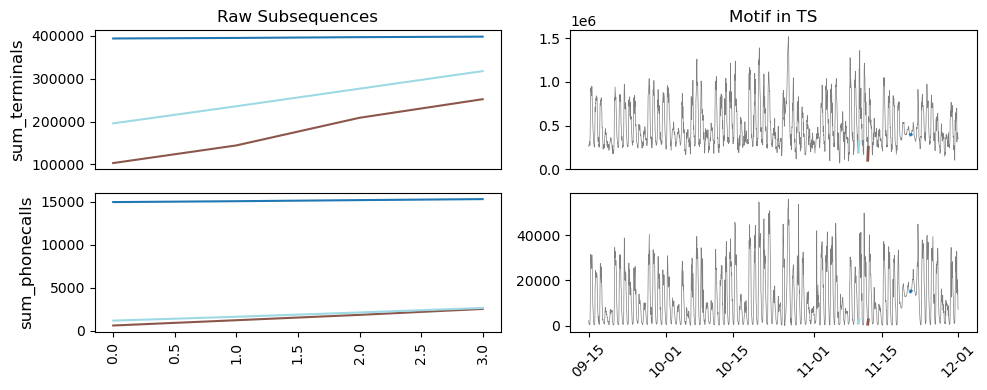

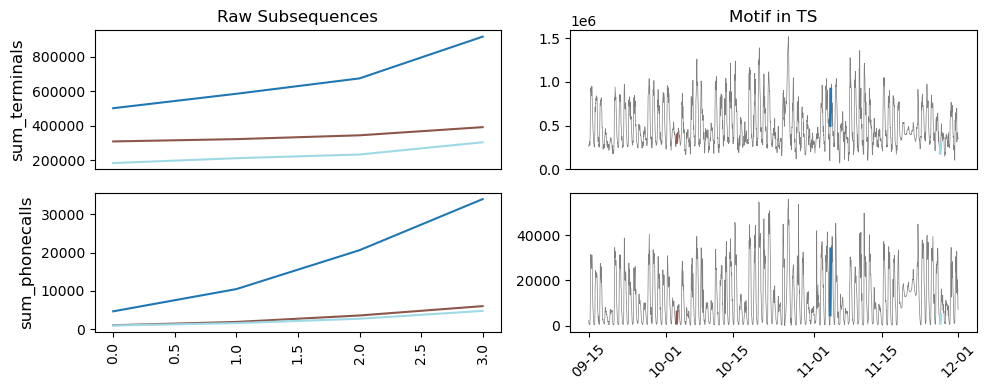

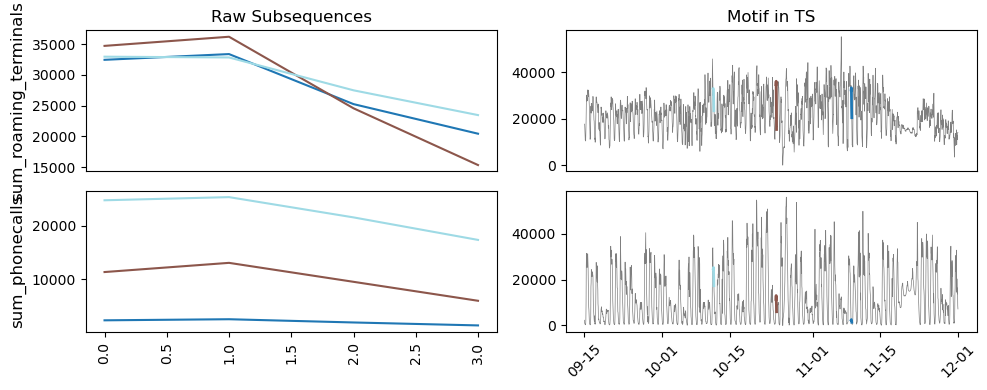

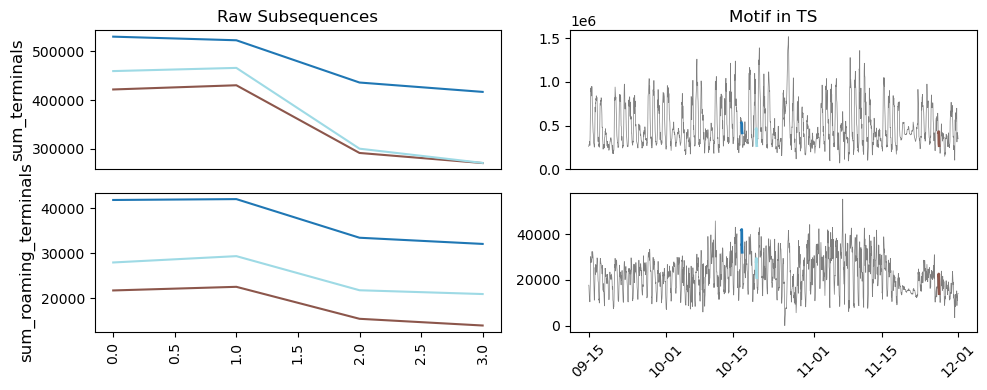

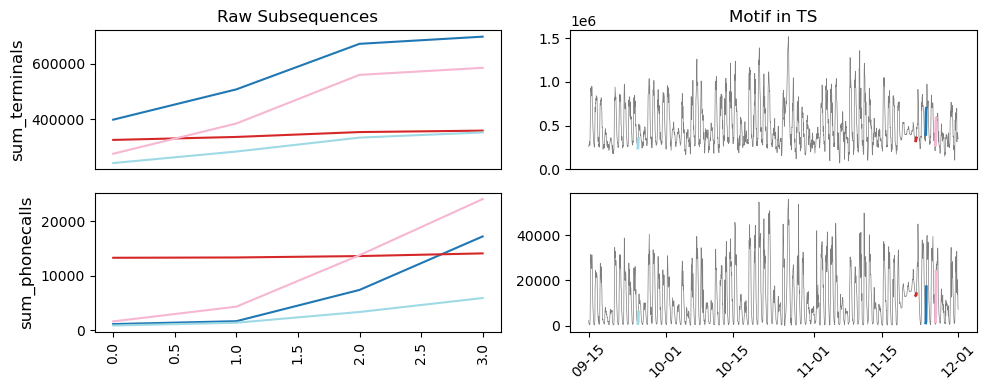

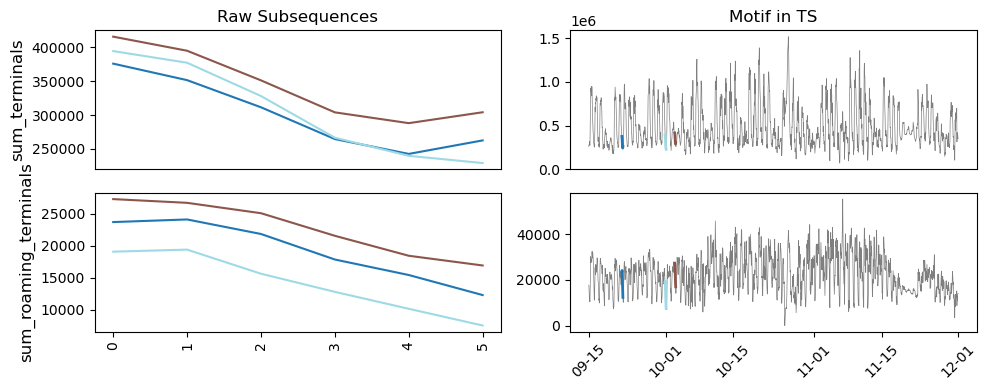

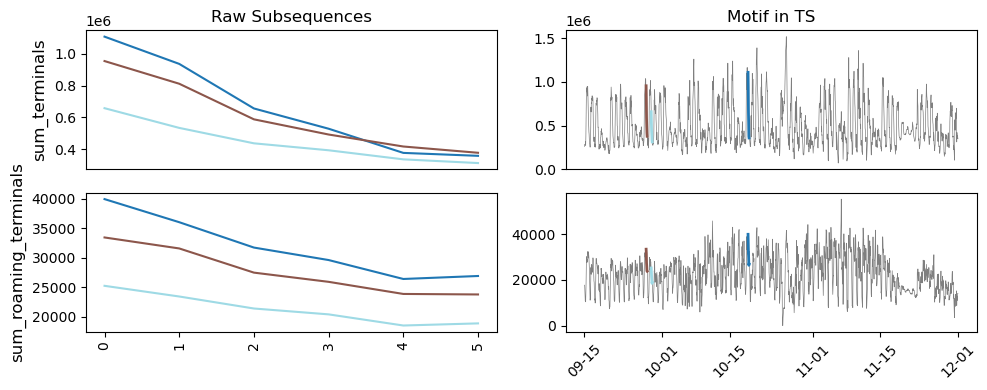

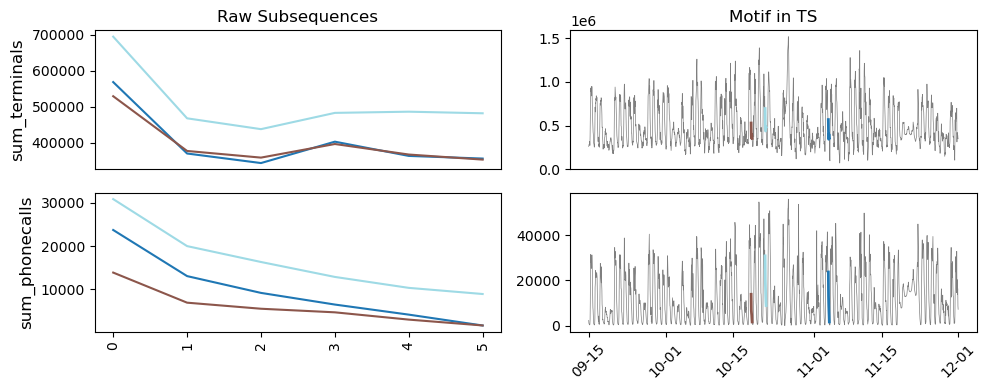

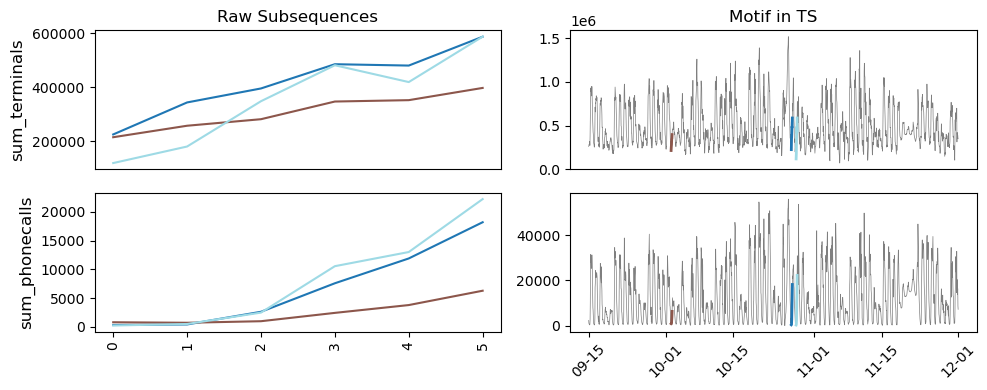

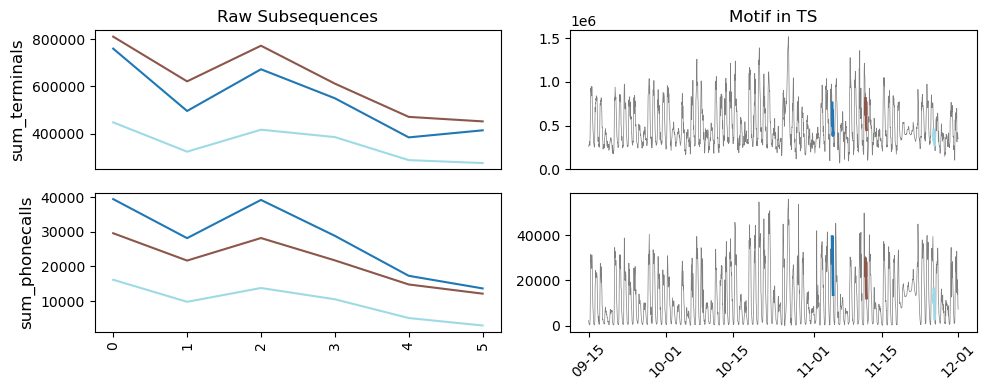

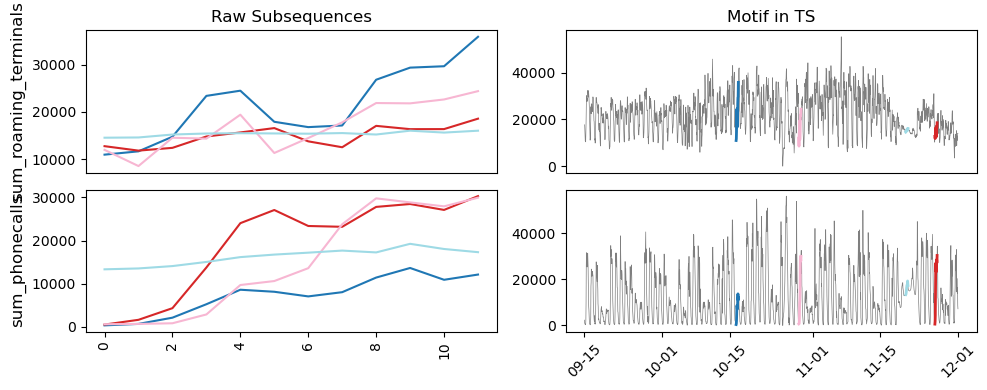

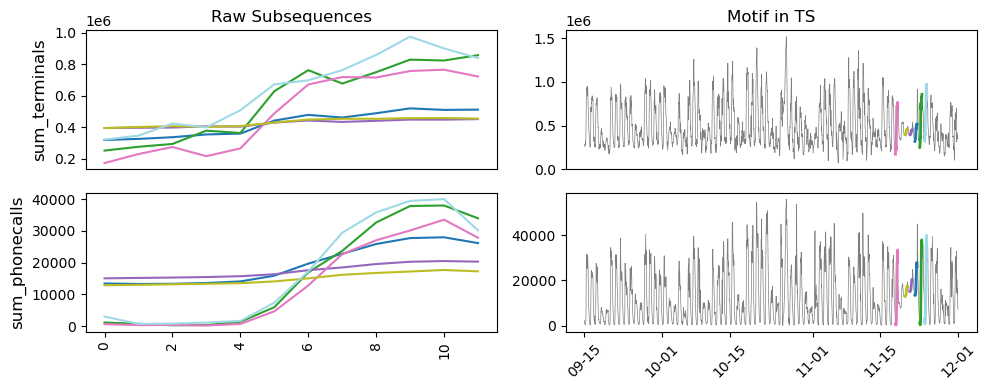

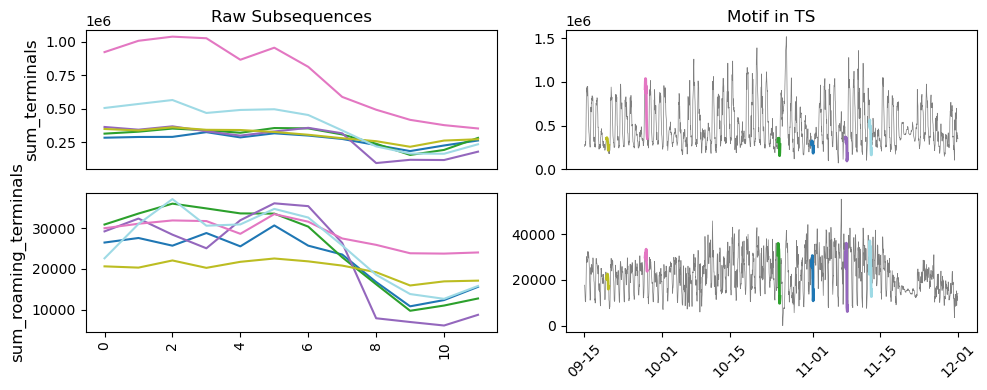

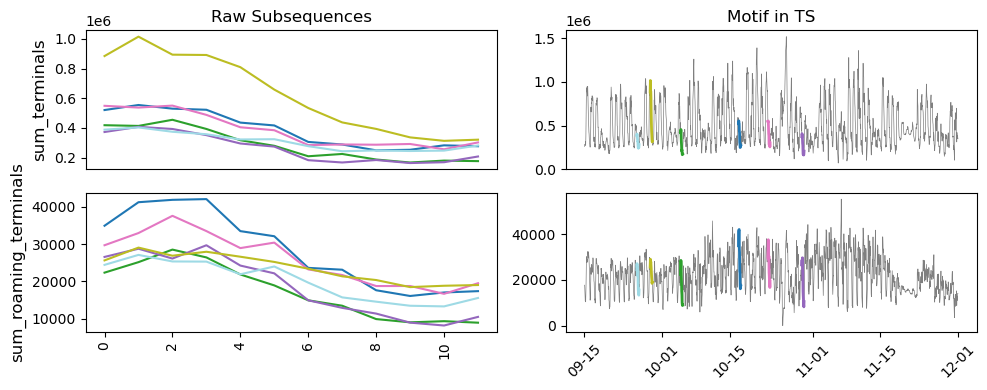

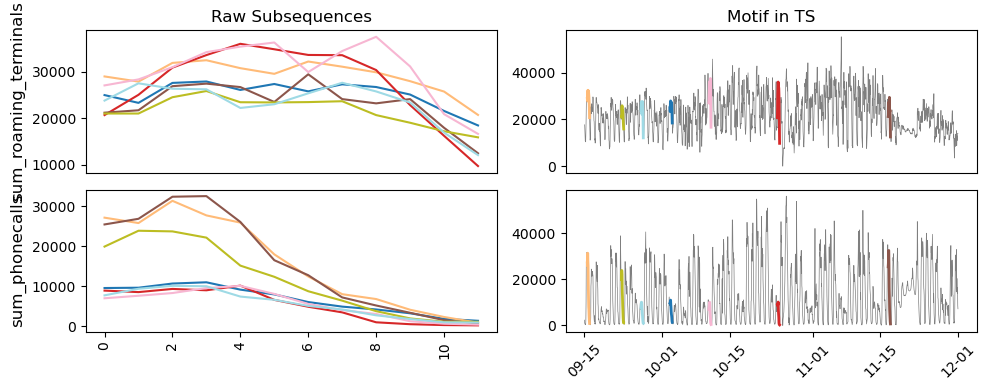

In [9]:
for m in subsequence_lengths:
    print("Motif length: ", m)
    top_motifs = mp_stats_table[mp_stats_table["m"] == m]
    top_motifs = top_motifs[top_motifs["k"] > 1].sort_values(by="#Matches").head()
    for top_motif in top_motifs.to_dict(orient="records"): 
        m = top_motif["m"]
        dimensions = top_motif["Features"].split(",")
        dimensions = sorted([int(dimension) for dimension in dimensions])
        features = [data_df.columns[dimension] for dimension in dimensions]
        indices = top_motif['Indices'].replace("[","").replace("]","").split(",")
        indices = [int(i) for i in indices]
        motif_name = top_motif["ID"]
        ts_list = [
            data_df.reset_index()[[feature] + ["one_time"]].set_index(["one_time"])
            for feature in features
        ]
        plot_motif(ts_list, features, m, indices, motif_name)